In [430]:
import pandas as pd

# Load the original dataset
original_df = pd.read_csv('data/NYC-Restaurant-Inspections/DOHMH_New_York_City_Restaurant_Inspection_Results.csv')

# Load the geocoded dataset
geocoded_df = pd.read_csv('data/NYC-Restaurant-Inspections/Geocoded_Locations.csv')

# Ensure 'IS_CLOSED' column exists before using it
geocoded_df['IS_CLOSED'] = 0

# Mark rows as closed if latitude or longitude is missing
geocoded_df['IS_CLOSED'] = geocoded_df.apply(
    lambda row: 1 if pd.isnull(row['LONGITUDE']) or pd.isnull(row['LATITUDE']) else row['IS_CLOSED'], axis=1
)

# Count the number of closed restaurants
closed_restaurants = geocoded_df['IS_CLOSED'].sum()
print(f"Number of closed restaurants: {closed_restaurants}")

# Add a unique row identifier to geocoded_df for tracking matches
geocoded_df['row_id'] = geocoded_df.index

# Perform an inner merge to find matching rows
matches_df = original_df.merge(
    geocoded_df,
    on=['BORO', 'STREET', 'BUILDING', 'ZIPCODE'], # Columns to match on
    how='inner'  # Only keep rows that match
)

# Count matches for each row in geocoded_df
match_counts = (
    matches_df.groupby('row_id')
    .size()  # Count the number of matches for each row_id
    .reindex(geocoded_df['row_id'], fill_value=0)  # Ensure alignment with geocoded_df
)

# Convert the counts to an array (optional for further use)
matches_array = match_counts.to_numpy()

# Optional: Print detailed match information for each geocoded row
print("\nDetailed matches per geocode row:")
for row_id, count in match_counts.items():
    row_data = geocoded_df.loc[row_id, ['BORO', 'STREET', 'BUILDING', 'ZIPCODE']].to_dict()
    print(f"Row {row_id} ({row_data}): {count} matches")

# Merge the two DataFrames (final merge to retain all rows from original_df)
merged_df = original_df.merge(
    geocoded_df[['BORO', 'STREET', 'BUILDING', 'ZIPCODE', 'LONGITUDE', 'LATITUDE', 'IS_CLOSED']],
    on=['BORO', 'STREET', 'BUILDING', 'ZIPCODE'], 
    how='left'  # Use 'left' to retain all rows from the original dataset
)

print("Total of merged closed restaurants because they're not existing anymore : ", merged_df['IS_CLOSED'].sum())

# Validate the total sum of matches
total_matches = match_counts.sum()
print(f"\nTotal matches: {total_matches}")

if total_matches == len(matches_df):
    print("Validation passed: Total matches align with the merged DataFrame.")
else:
    print("Validation failed: Mismatch between total matches and merged DataFrame length.")

Number of closed restaurants: 224

Detailed matches per geocode row:
Row 0 ({'BORO': 'MANHATTAN', 'STREET': 'SECOND AVENUE', 'BUILDING': '635', 'ZIPCODE': 10016.0}): 38 matches
Row 1 ({'BORO': 'MANHATTAN', 'STREET': 'SECOND AVENUE', 'BUILDING': '635', 'ZIPCODE': 10016.0}): 38 matches
Row 2 ({'BORO': 'QUEENS', 'STREET': 'BROADWAY', 'BUILDING': '2507', 'ZIPCODE': 11106.0}): 5 matches
Row 3 ({'BORO': 'STATEN ISLAND', 'STREET': 'HOLDEN BLVD', 'BUILDING': '11C', 'ZIPCODE': 10314.0}): 7 matches
Row 4 ({'BORO': 'BROOKLYN', 'STREET': '5 AVENUE', 'BUILDING': '8015', 'ZIPCODE': 11209.0}): 14 matches
Row 5 ({'BORO': 'QUEENS', 'STREET': 'MAIN ST', 'BUILDING': '4339', 'ZIPCODE': 11355.0}): 36 matches
Row 6 ({'BORO': 'BROOKLYN', 'STREET': '4TH AVE', 'BUILDING': '256', 'ZIPCODE': 11215.0}): 24 matches
Row 7 ({'BORO': 'STATEN ISLAND', 'STREET': 'TODT HILL ROAD', 'BUILDING': '1122', 'ZIPCODE': 10304.0}): 7 matches
Row 8 ({'BORO': 'STATEN ISLAND', 'STREET': 'FOREST AVENUE', 'BUILDING': '480', 'ZIPCODE':

In [431]:
# Okay now we select the columns we want to keep 
df_selected = merged_df[['LONGITUDE', 'LATITUDE', 'INSPECTION DATE', 'ACTION', 'CRITICAL FLAG', 'SCORE', 'IS_CLOSED', 'CUISINE DESCRIPTION']]

print(df_selected.dtypes)

print(df_selected['IS_CLOSED'].value_counts())

df_selected.fillna({
    'SCORE': df_selected['SCORE'].median(),
    'ACTION': -1,
    'CRITICAL FLAG': -1
}, inplace=True)

# Drop rows with missing values of the selected columns
df_selected = df_selected.dropna(subset=['LONGITUDE', 'LATITUDE', 'INSPECTION DATE', 'ACTION', 'CRITICAL FLAG', 'SCORE', 'IS_CLOSED', 'CUISINE DESCRIPTION'])

#See the length of the dataset after cleaning
print('Original dataset length:', len(original_df))
print('Number of rows now:', len(df_selected))

LONGITUDE              float64
LATITUDE               float64
INSPECTION DATE         object
ACTION                  object
CRITICAL FLAG           object
SCORE                  float64
IS_CLOSED              float64
CUISINE DESCRIPTION     object
dtype: object
IS_CLOSED
0.0    141409
1.0      5252
Name: count, dtype: int64
Original dataset length: 399918
Number of rows now: 141409


/var/folders/zn/lg0pkz2s1jx5_05f7f4b5c2h0000gn/T/ipykernel_80805/3520237104.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.fillna({


We're gonna need to certainly balance the DATASET

<Axes: >

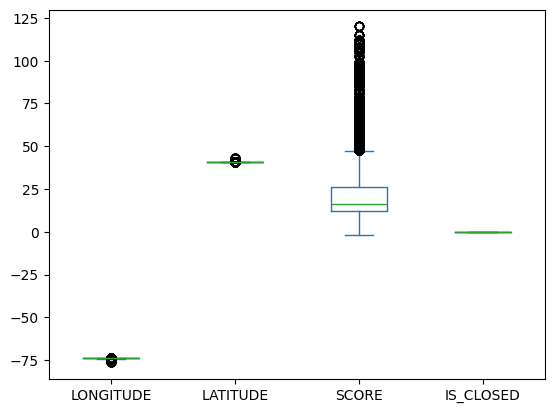

In [432]:
df_selected.plot.box()

We've a little anomaly for the date because of the inspection who are from 1900

In [433]:
# in inspection date just keep the year
df_selected['INSPECTION DATE'] = pd.to_datetime(df_selected['INSPECTION DATE'])
df_selected['INSPECTION DATE'] = df_selected['INSPECTION DATE'].dt.year


# Drop the values that are from 1900
df_selected = df_selected[df_selected['INSPECTION DATE'] != 1900]

print(df_selected['INSPECTION DATE'].value_counts())


INSPECTION DATE
2015    45136
2016    38976
2014    31055
2017    23924
2013     2226
Name: count, dtype: int64


In [434]:
# Créer un dictionnaire de mappage
action_mapping = {
    'Violations were cited in the following area(s).': 1,
    'No violations were recorded at the time of this inspection.': 0,
    'Establishment re-opened by DOHMH': 2,
    'Establishment re-closed by DOHMH': 3,
    'Establishment Closed by DOHMH.  Violations were cited in the following area(s) and those requiring immediate action were addressed.': 4,
    'Missing': -1
}

# Appliquer le mappage à la colonne Action
df_selected['ACTION'] = df_selected['ACTION'].map(action_mapping)

print(df_selected['ACTION'].value_counts())

ACTION
1    133538
4      4107
0      2068
2      1188
3       416
Name: count, dtype: int64


/var/folders/zn/lg0pkz2s1jx5_05f7f4b5c2h0000gn/T/ipykernel_80805/2179318784.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['ACTION'] = df_selected['ACTION'].map(action_mapping)


In [435]:
# Créer un dictionnaire de mappage
critical_flag_mapping = {
    'Critical': 1,
    'Not Critical': 0,
    'Not Applicable': -1
}

# Appliquer le mappage à la colonne Critical Flag
df_selected['CRITICAL FLAG'] = df_selected['CRITICAL FLAG'].map(critical_flag_mapping)

/var/folders/zn/lg0pkz2s1jx5_05f7f4b5c2h0000gn/T/ipykernel_80805/3048315063.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['CRITICAL FLAG'] = df_selected['CRITICAL FLAG'].map(critical_flag_mapping)


In [436]:
#See now all the types if they are correct
print(df_selected.dtypes)

LONGITUDE              float64
LATITUDE               float64
INSPECTION DATE          int32
ACTION                   int64
CRITICAL FLAG            int64
SCORE                  float64
IS_CLOSED              float64
CUISINE DESCRIPTION     object
dtype: object


In [437]:
# count the number of restaurant where is_closed is 1 and the action is 3 or 4
numberOfClosedRestaurants = df_selected[(df_selected['IS_CLOSED'] == 1) & (df_selected['ACTION'].isin([3, 4]))].shape[0]
print(f"Number of closed restaurants with action 3 or 4: {numberOfClosedRestaurants}")

df_selected['IS_CLOSED'] = df_selected.apply(
    lambda row: 1 if row['IS_CLOSED'] == 1 or row['ACTION'] in [3, 4] else 0, axis=1
)

print(df_selected['IS_CLOSED'].value_counts())

Number of closed restaurants with action 3 or 4: 0
IS_CLOSED
0    136794
1      4523
Name: count, dtype: int64


/var/folders/zn/lg0pkz2s1jx5_05f7f4b5c2h0000gn/T/ipykernel_80805/375921755.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['IS_CLOSED'] = df_selected.apply(


In [438]:
# We will normalize the score column
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_selected['SCORE'] = scaler.fit_transform(df_selected[['SCORE']])

# Count the number of identical scores for each scores
score_counts = df_selected['SCORE'].value_counts()

# Display the counts
print(score_counts)

SCORE
0.114754    12160
0.139344    10375
0.122951     8590
0.098361     6911
0.106557     6834
            ...  
0.877049        9
0.811475        8
1.000000        8
0.729508        7
0.000000        3
Name: count, Length: 108, dtype: int64


/var/folders/zn/lg0pkz2s1jx5_05f7f4b5c2h0000gn/T/ipykernel_80805/279763134.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['SCORE'] = scaler.fit_transform(df_selected[['SCORE']])


Closed restaurants: (4523, 8)
Open restaurants: (4000, 8)
Final dataset: (8523, 8)


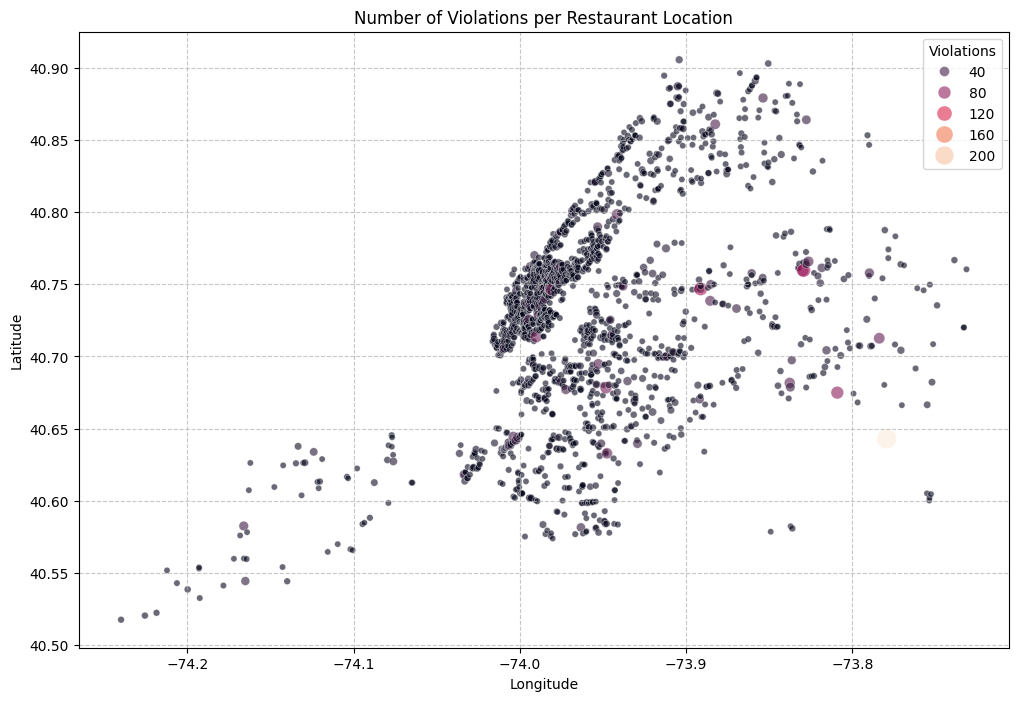

In [439]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter closed restaurants with valid GPS coordinates
closed_restaurants = df_selected[
    (df_selected['IS_CLOSED'] == 1) & 
    (df_selected['LONGITUDE'].notnull()) & 
    (df_selected['LATITUDE'].notnull())
]
print(f"Closed restaurants: {closed_restaurants.shape}")

# Step 2: Sample 4000 open restaurants with valid GPS coordinates
open_restaurants = df_selected[
    (df_selected['IS_CLOSED'] == 0) & 
    (df_selected['LONGITUDE'].notnull()) & 
    (df_selected['LATITUDE'].notnull())
].sample(4000, random_state=42)
print(f"Open restaurants: {open_restaurants.shape}")

# Step 3: Combine both datasets
final_df = pd.concat([closed_restaurants, open_restaurants])
print(f"Final dataset: {final_df.shape}")

# Step 4: Count violations per restaurant location
violations_per_restaurant = (
    final_df.groupby(['LONGITUDE', 'LATITUDE'])
    .size()
    .reset_index(name='VIOLATIONS')
)

# Step 5: Create the scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=violations_per_restaurant,
    x='LONGITUDE',
    y='LATITUDE',
    hue='VIOLATIONS',  # Map violations to color
    size='VIOLATIONS',  # Map violations to size
    palette='rocket',  # Use a high-contrast color palette
    sizes=(20, 200),  # Adjust size range for better visibility
    alpha=0.6,  # Add transparency for overlapping points
    legend='brief'  # Enable legend for better interpretation
)
plt.title('Number of Violations per Restaurant Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Violations', loc='upper right')  # Optional: Customize legend
plt.show()


We Can clearly see that there is an area in the center where we have a lot of restaurants, so we can concluse that our model will tend to concentrate mainly in this area

In [440]:
# Okay now we will create an indice based on the number of violations and the longitude and latitude between 0 and 1 to see in an area or not is most likely to have a closed restaurant
# Step 1: Compute the total number of violations per location
violations_per_location = (
    final_df.groupby(['LONGITUDE', 'LATITUDE'])
    .size()
    .reset_index(name='VIOLATIONS')
)

# Step 2: Normalize the number of violations to the range [0, 1]
violations_per_location['VIOLATIONS'] = scaler.fit_transform(violations_per_location[['VIOLATIONS']])

# Step 3: Compute the location score based on violations and coordinates in a range of [0, 1]
violations_per_location['LOCATION_SCORE'] = (
    violations_per_location['VIOLATIONS'] * 0.5  # Weight for violations
    + violations_per_location['LONGITUDE'].sub(violations_per_location['LONGITUDE'].min()).div(violations_per_location['LONGITUDE'].max() - violations_per_location['LONGITUDE'].min()) * 0.25  # Weight for longitude
    + violations_per_location['LATITUDE'].sub(violations_per_location['LATITUDE'].min()).div(violations_per_location['LATITUDE'].max() - violations_per_location['LATITUDE'].min()) * 0.25  # Weight for latitude
)

# Step 4: Display the top 10 locations with the highest location score
top_locations = violations_per_location.nlargest(10, 'LOCATION_SCORE')
print(top_locations)

final_df = final_df.merge(violations_per_location[['LONGITUDE', 'LATITUDE', 'LOCATION_SCORE']], on=['LONGITUDE', 'LATITUDE'], how='left')

      LONGITUDE   LATITUDE  VIOLATIONS  LOCATION_SCORE
1776 -73.779373  40.642948    1.000000        0.807173
1718 -73.829272  40.759718    0.414414        0.565031
1554 -73.891248  40.746876    0.405405        0.521793
1716 -73.829932  40.759630    0.310811        0.512847
1662 -73.853744  40.879236    0.162162        0.503822
1724 -73.827678  40.864143    0.135135        0.493404
1594 -73.882495  40.861061    0.189189        0.491501
1752 -73.809057  40.674944    0.351351        0.488857
1772 -73.783817  40.712646    0.252252        0.475987
1725 -73.826392  40.765876    0.202703        0.464554


/var/folders/zn/lg0pkz2s1jx5_05f7f4b5c2h0000gn/T/ipykernel_80805/1193791890.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


CUISINE DESCRIPTION
American                                                            34370
Chinese                                                             15038
Latin (Cuban, Dominican, Puerto Rican, South & Central American)     6769
Japanese                                                             5922
Italian                                                              5681
                                                                    ...  
Creole/Cajun                                                           21
Nuts/Confectionary                                                     15
Egyptian                                                               13
Hawaiian                                                               12
Californian                                                             6
Name: ACTION, Length: 80, dtype: int64


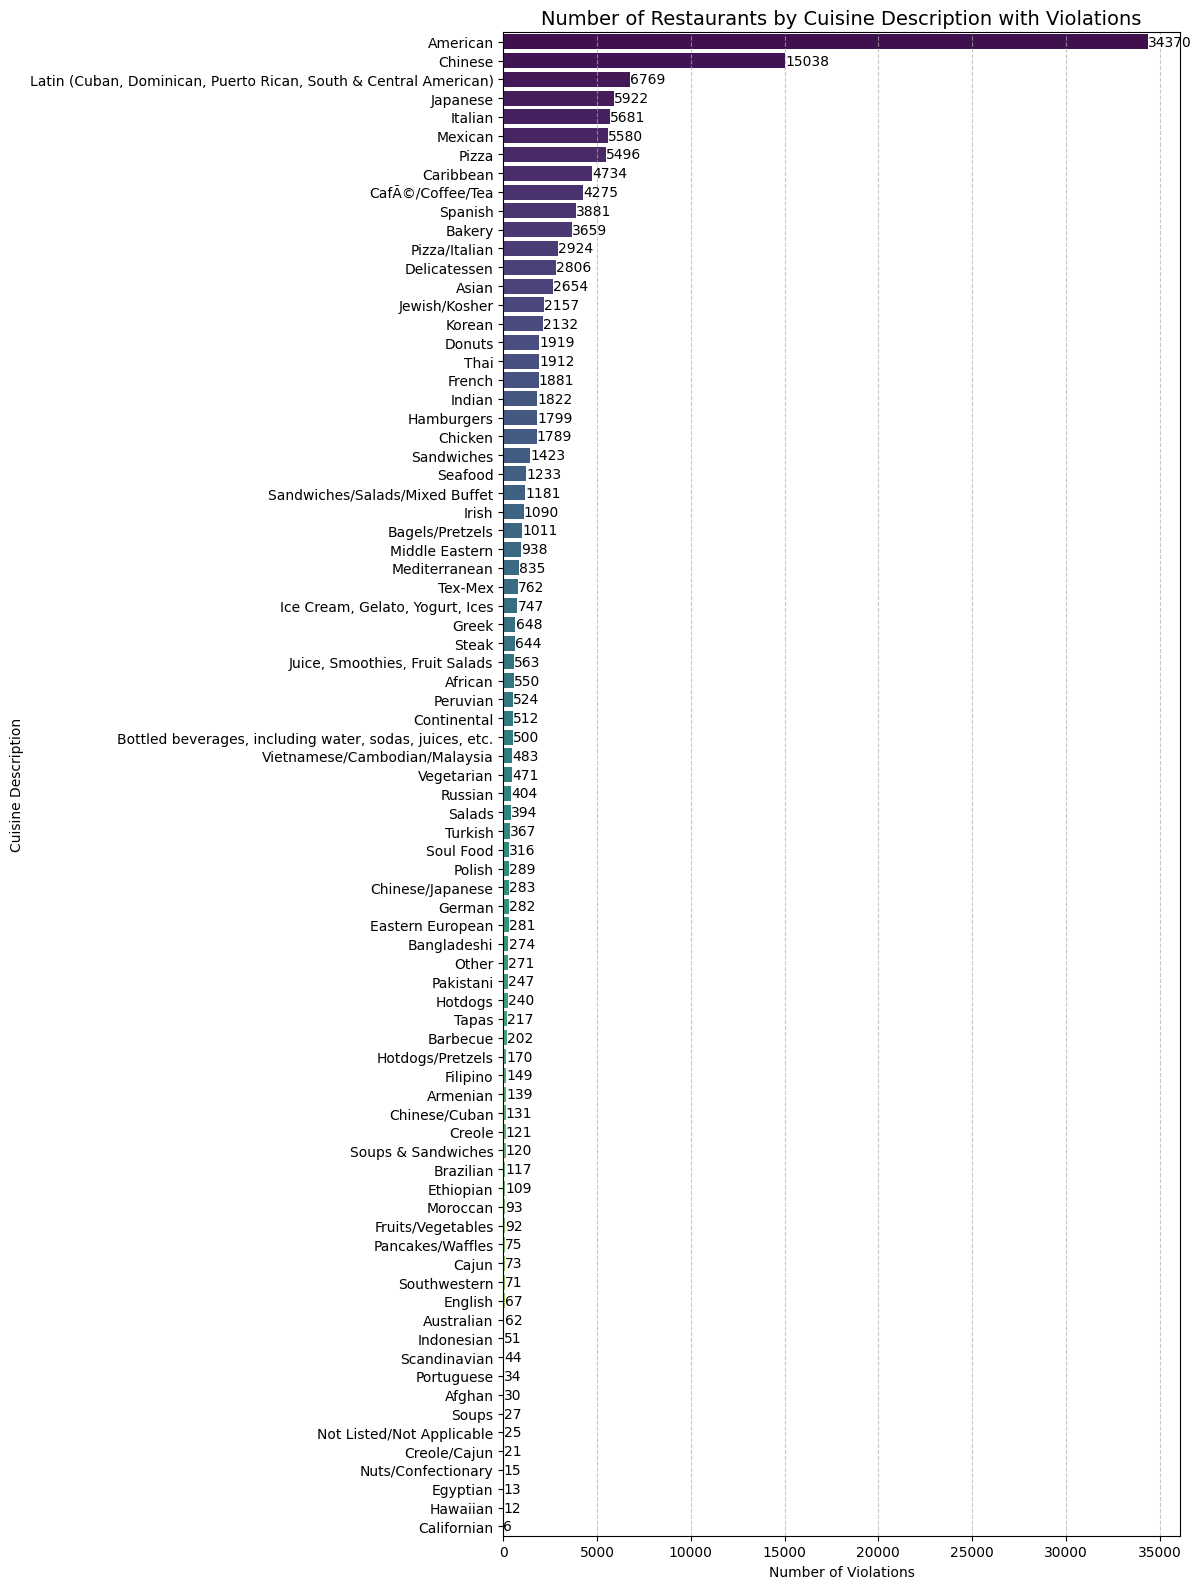

In [441]:
# Aggregate violations by cuisine description

# take the sum of violations for each cuisine description so where ACTION is not equal to 0 or -1
violations_per_cuisine = df_selected.groupby('CUISINE DESCRIPTION')['ACTION'].apply(lambda x: (x != 0).sum()).sort_values(ascending=False)

print(violations_per_cuisine)

# Plot the bar chart
plt.figure(figsize=(12, 16))
sns.barplot(
    y=violations_per_cuisine.index,
    x=violations_per_cuisine.values,
    palette='viridis'
)

# Annotate bars with the number of violations
for index, value in enumerate(violations_per_cuisine):
    plt.text(
        value + 5,  # Position the text slightly to the right of the bar
        index,  # Align with the corresponding bar
        f'{value}',  # The violation count
        va='center',  # Vertical alignment
        fontsize=10,
        color='black'
    )

# Add labels and grid
plt.title('Number of Restaurants by Cuisine Description with Violations', fontsize=14)
plt.xlabel('Number of Violations')
plt.ylabel('Cuisine Description')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

I would like to represent the % of the violation on the total of restaurant in each cuisine type but as our data is not balanced and mostly contain the violation of the restaurants, I cannot really do this analysis, it wouldn't be relevant. 😞

/var/folders/zn/lg0pkz2s1jx5_05f7f4b5c2h0000gn/T/ipykernel_80805/3639530527.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


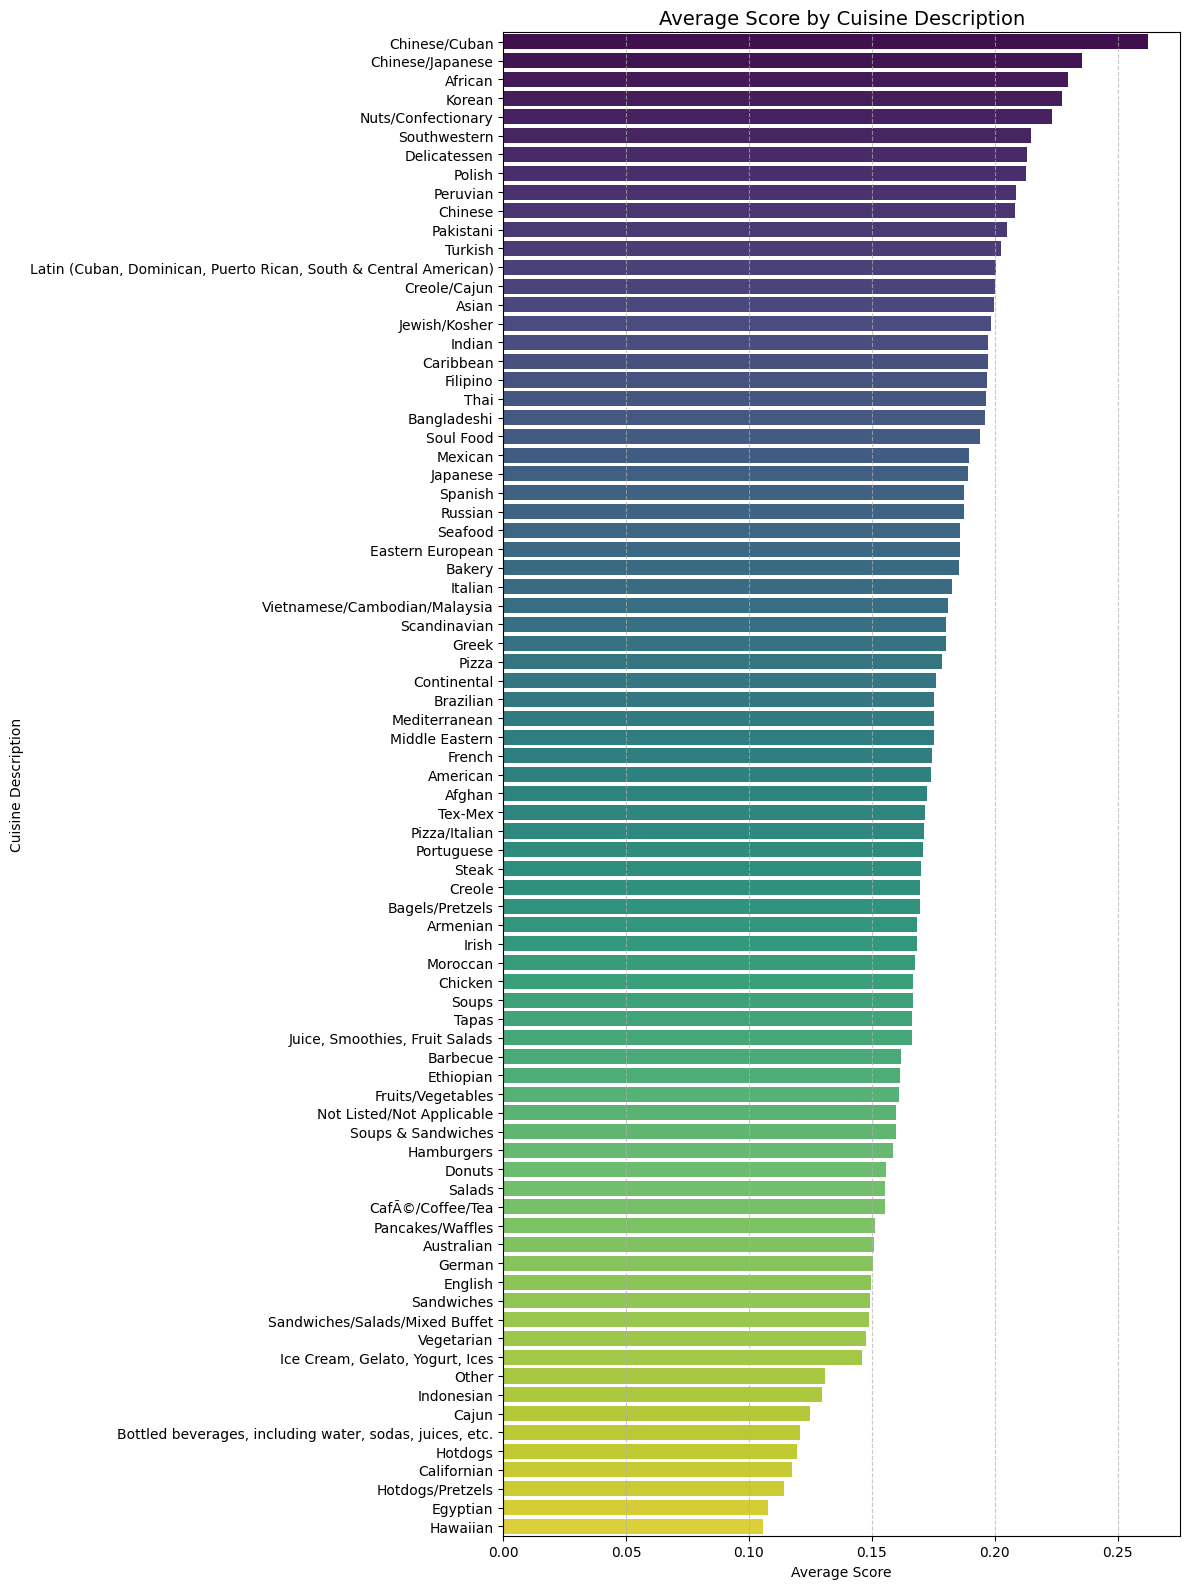

In [442]:
# I think it can be interesting to see each score for each cuisine description
# Aggregate scores by cuisine description
scores_per_cuisine = df_selected.groupby('CUISINE DESCRIPTION')['SCORE'].mean().sort_values(ascending=False)

# Plot the bar chart
plt.figure(figsize=(12, 16))
sns.barplot(
    y=scores_per_cuisine.index,
    x=scores_per_cuisine.values,
    palette='viridis'
)
plt.title('Average Score by Cuisine Description', fontsize=14)
plt.xlabel('Average Score')
plt.ylabel('Cuisine Description')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Interesting ! Because the best score is not the most common and the worst score is not the less common

In [443]:
# Verify the % of each value of IS_CLOSED
print(final_df['IS_CLOSED'].value_counts(normalize=True))

# See the number value of each value of IS_CLOSED
print(final_df['IS_CLOSED'].value_counts())

IS_CLOSED
1    0.530682
0    0.469318
Name: proportion, dtype: float64
IS_CLOSED
1    4523
0    4000
Name: count, dtype: int64


So, now the set is correctly balanced, we can see that the most common score is 0 and the less common is 1

<Axes: >

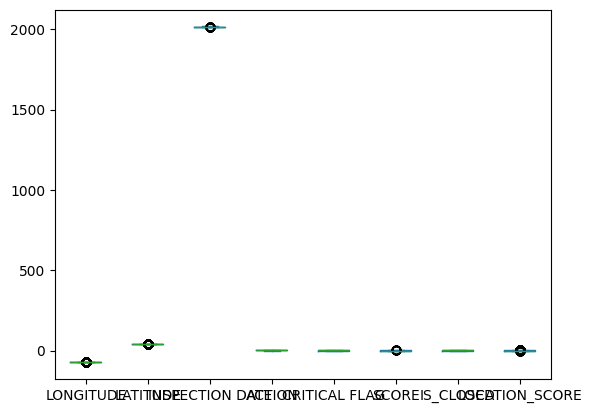

In [444]:
final_df.plot.box()

In [445]:
# Update the cuisine description column by regrouping cuisine with low impact

cuisine_counts = final_df['CUISINE DESCRIPTION'].value_counts()
rare_cuisines = cuisine_counts[cuisine_counts < 50].index
final_df['CUISINE DESCRIPTION'] = final_df['CUISINE DESCRIPTION'].replace(rare_cuisines, 'Other')

In [446]:
# %%
## MODELING
import os
from dotenv import load_dotenv
import comet_ml
from comet_ml.integration.sklearn import log_model

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

load_dotenv()

MODEL_NAME = "AI-la-Carte-Random_ForestV4"
WORKSPACE = os.environ["COMET_WORKSPACE"]


comet_ml.login()
experiment = comet_ml.start(
    project_name="ai-la-carte",
)

# Define features and target
#? Critical flag -> 1 Critical, 0 Not Critical, -1 Not Applicable
X = final_df[['LONGITUDE', 'LATITUDE', 'SCORE', 'CRITICAL FLAG', 'CUISINE DESCRIPTION', 'LOCATION_SCORE', 'INSPECTION DATE']]
y = final_df['IS_CLOSED']

# print the first rows of the dataset
print(X.dtypes)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/n0ku/ai-la-carte/10885798f463434b96aaebb7c7581a15



LONGITUDE              float64
LATITUDE               float64
SCORE                  float64
CRITICAL FLAG            int64
CUISINE DESCRIPTION     object
LOCATION_SCORE         float64
INSPECTION DATE          int32
dtype: object


In [456]:
from sklearn.decomposition import PCA

# Update the preprocessing pipeline
preprocessor = ColumnTransformer(
  transformers=[
        ('num', StandardScaler(), ['LONGITUDE', 'LATITUDE', 'SCORE', 'CRITICAL FLAG', 'LOCATION_SCORE', 'INSPECTION DATE']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['CUISINE DESCRIPTION']),
        ('pca', PCA(n_components=2), ['LONGITUDE', 'LATITUDE'])
    ]
)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define models
log_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])


random_forest = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train and evaluate Logistic Regression
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))
print("AUC-ROC:", roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1]))

# Train and evaluate Random Forest
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
print("Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(y_test, random_forest.predict_proba(X_test)[:, 1]))

# print the differnce between the train and test score
print("Train score Logistic Regression: ", log_reg.score(X_train, y_train))
print("Test score Logistic Regression: ", log_reg.score(X_test, y_test))

# print the differnce between the train and test score
print("Train score Random Forest: ", random_forest.score(X_train, y_train))
print("Test score Random Forest: ", random_forest.score(X_test, y_test))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       800
           1       0.88      0.84      0.86       905

    accuracy                           0.86      1705
   macro avg       0.85      0.86      0.85      1705
weighted avg       0.86      0.86      0.86      1705

AUC-ROC: 0.9184447513812155
Random Forest:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       800
           1       0.95      0.99      0.97       905

    accuracy                           0.97      1705
   macro avg       0.97      0.97      0.97      1705
weighted avg       0.97      0.97      0.97      1705

AUC-ROC: 0.9926388121546961
Train score Logistic Regression:  0.8583162217659137
Test score Logistic Regression:  0.8551319648093841
Train score Random Forest:  0.9994133176884717
Test score Random Forest:  0.9689149560117302


After applying Scaler on score, and create a corelation between the gps coordinates and the violation number for each restaurant I hit an AUC of 0.989 which is pretty good, for a simple model like this one

Even after trying other model this one is the best, providing us a good AUC of alreay 0.97 before tuning the hyperparameters and create supllimentary features.

On train we have a AUC of 0.99 and on test 0.95

ImportError: Numba needs NumPy 2.0 or less. Got NumPy 2.2.

In [448]:
# Introspect the model
print("Feature Importance:")
# Get feature names after preprocessing
num_features = random_forest.named_steps['preprocessor'].named_transformers_['num'].get_feature_names_out().tolist()
cat_features = random_forest.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out().tolist()
feature_names = num_features + cat_features

# Get feature importances
feature_importance = random_forest.named_steps['classifier'].feature_importances_

# Ensure the lengths match
if len(feature_names) == len(feature_importance):
	# Create a DataFrame for feature importances
	feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
	print(feature_importance_df.sort_values('Importance', ascending=False).head(10))
else:
	print("Error: Mismatch in feature names and importances lengths")

Feature Importance:
                          Feature  Importance
2                           SCORE    0.533347
4                  LOCATION_SCORE    0.111786
1                        LATITUDE    0.098381
0                       LONGITUDE    0.096443
5                 INSPECTION DATE    0.044265
3                   CRITICAL FLAG    0.012531
6    CUISINE DESCRIPTION_American    0.011017
10  CUISINE DESCRIPTION_Caribbean    0.007715
12    CUISINE DESCRIPTION_Chinese    0.007542
27      CUISINE DESCRIPTION_Other    0.006820


In [449]:
import cloudpickle

log_model(experiment, MODEL_NAME, random_forest, persistence_module=cloudpickle)
experiment.register_model(MODEL_NAME)

experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : fancy_anaconda_3146
COMET INFO:     url                   : https://www.comet.com/n0ku/ai-la-carte/10885798f463434b96aaebb7c7581a15
COMET INFO:   Parameters:
COMET INFO:     C                                        : 1.0
COMET INFO:     bootstrap                                : True
COMET INFO:     ccp_alpha                                : 0.0
COMET INFO:     class_weight                             : None
COMET INFO:     classifier_C                             : 1.0
COMET INFO:     classifier__C                            : 1.0
COMET INFO:     classifier__bootstrap                    : True
COMET INFO:     classifier__ccp_alpha                   

In [450]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'classifier__n_estimators': randint(400, 500),
    'classifier__max_depth': randint(15, 25)
}

random_search = RandomizedSearchCV(random_forest, param_dist, n_iter=50, cv=5, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)
print("Best parameters:", random_search.best_params_)

Best parameters: {'classifier__max_depth': 24, 'classifier__n_estimators': 491}


In [451]:
# Define best hyperparameter grid for Random Forest
param_grid = {
    'classifier__n_estimators': [300,400, 500],
    'classifier__max_depth': [20, 25, 30, 35]
}

grid_search = GridSearchCV(random_forest, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
y_pred_gs = grid_search.predict(X_test)
print("Grid Search Random Forest:")
print(classification_report(y_test, y_pred_gs))
print("AUC-ROC:", roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1]))


Best parameters: {'classifier__max_depth': 35, 'classifier__n_estimators': 500}
Best score: 0.940892631615184
Grid Search Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       800
           1       0.95      0.98      0.96       905

    accuracy                           0.96      1705
   macro avg       0.96      0.96      0.96      1705
weighted avg       0.96      0.96      0.96      1705

AUC-ROC: 0.9920607734806629


In [452]:
# Save the Random Forest model as it seems to be the best for now
import joblib

joblib.dump(random_forest, 'models/restaurant_closures_rf.pkl')

['models/restaurant_closures_rf.pkl']

In [453]:
# Import required libraries
import xgboost as xgb

# Initialize the XGBClassifier with explicitly set parameters
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=1,
    random_state=42,
    eval_metric='logloss'
)

# Create a pipeline with the preprocessor and the XGBClassifier
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

# Train the XGBClassifier
xgb_pipeline.fit(X_train, y_train)

# Predict and evaluate the model
y_pred_xgb = xgb_pipeline.predict(X_test) #! NOTE: because of a problem with the current version of xgboost, we can't use predict
print("XGBoost Classifier:")
print(classification_report(y_test, y_pred_xgb))
print("AUC-ROC:", roc_auc_score(y_test, xgb_pipeline.predict_proba(X_test)[:, 1]))

/Users/n0ku/Desktop/Projects/Python/PythonIA/.venv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [355]:
from sklearn.ensemble import HistGradientBoostingClassifier

# Initialize the HistGradientBoostingClassifier
hist_gb = HistGradientBoostingClassifier(random_state=42)

# Create a pipeline with the preprocessor and the HistGradientBoostingClassifier
hist_gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', hist_gb)
])

# Add a step to convert sparse matrix to dense array in the pipeline
from sklearn.preprocessing import FunctionTransformer

dense_transformer = FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)

# Create a pipeline with the preprocessor, dense transformer, and HistGradientBoostingClassifier
hist_gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('to_dense', dense_transformer),
    ('classifier', hist_gb)
])

# Train the HistGradientBoostingClassifier
hist_gb_pipeline.fit(X_train, y_train)

# Predict and evaluate the model
y_pred_hist_gb = hist_gb_pipeline.predict(X_test)
print("HistGradientBoosting Classifier:")
print(classification_report(y_test, y_pred_hist_gb))
print("AUC-ROC:", roc_auc_score(y_test, hist_gb_pipeline.predict_proba(X_test)[:, 1]))

# print test and train score
print("Train score HistGradientBoosting: ", hist_gb_pipeline.score(X_train, y_train))
print("Test score HistGradientBoosting: ", hist_gb_pipeline.score(X_test, y_test))


HistGradientBoosting Classifier:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       800
           1       0.93      0.96      0.94       905

    accuracy                           0.94      1705
   macro avg       0.94      0.94      0.94      1705
weighted avg       0.94      0.94      0.94      1705

AUC-ROC: 0.9803756906077348
Train score HistGradientBoosting:  0.9647990613083015
Test score HistGradientBoosting:  0.9378299120234604


That's better than the Logistic Regression model, but still not enough to be used in production, the random forest model is still the best one

In [455]:
from sklearn.decomposition import PCA

# Update the preprocessing pipeline with PCA
preprocessor_pca = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['LONGITUDE', 'LATITUDE', 'SCORE', 'CRITICAL FLAG', 'LOCATION_SCORE', 'INSPECTION DATE']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['CUISINE DESCRIPTION']),
        ('pca', PCA(n_components=2), ['LONGITUDE', 'LATITUDE'])
    ]
)

# Define the Random Forest model with PCA
random_forest_pca = Pipeline([
    ('preprocessor', preprocessor_pca),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train and evaluate Random Forest with PCA
random_forest_pca.fit(X_train, y_train)
y_pred_rf_pca = random_forest_pca.predict(X_test)
print("Random Forest with PCA:")
print(classification_report(y_test, y_pred_rf_pca))
print("AUC-ROC:", roc_auc_score(y_test, random_forest_pca.predict_proba(X_test)[:, 1]))

# the main model was updated

Random Forest with PCA:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       800
           1       0.95      0.99      0.97       905

    accuracy                           0.97      1705
   macro avg       0.97      0.97      0.97      1705
weighted avg       0.97      0.97      0.97      1705

AUC-ROC: 0.9926388121546961
